# Exploring the generated chunks of code
# Were they in the training dataset?

To run this notebook,
- prepare the results first by running the script `./generate_code_chunks.sh`
- put your GitHub API token into `GITHUB_API_TOKEN` variable to be able to check if a chunk of code is available on GitHub

In [ ]:
%set_env GITHUB_API_TOKEN=#####YOUR_TOKEN#######

In [149]:
from github_search import get_gh_occurence_count, search_github

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

In [150]:
def plot_1b_3b(
    dataframe: pd.DataFrame,
    title: str = "3b doesn't differ much from 1b",
    log_scale: bool = False,
    close_before: bool = True
):
    if close_before:
        plt.close()

    plt.title(title)
    plt.plot(dataframe.perp_1b, "o", label="starcoder-1b")
    plt.plot(dataframe.perp_3b, "o", label="starcoder-3b")
    if log_scale:
        plt.yscale("log")
    
    plt.ylabel("perplexity")
    plt.legend()
    plt.grid()

In [151]:
# Load the results, sort by perplexity
df = pd.read_csv("code_chunks_and_scores.csv", index_col=0)
df = df.sort_values(by="perp_3b", ignore_index=True)
df.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,perp_1b,perp_3b,zlib_entropy,perp_3b_lowercase,sliding_window
count,5039.000000,5039.000000,5040.000000,5039.000000,5040.000000
mean,14.789309,27.333283,292.324405,15.611288,inf
std,538.004941,1330.446171,145.804142,538.163866,NaN
min,1.037361,1.038456,9.000000,1.037361,1.062612
25%,2.235592,2.442429,172.000000,2.514572,2.215289
50%,3.087881,3.484168,307.000000,3.496672,3.158813
75%,4.487130,5.189832,398.000000,5.091545,4.797093
max,38078.542969,94303.382812,733.000000,38078.542969,inf


In [152]:
# Check none and inf value counts per column
df.replace(np.inf, np.nan).isna().sum()

texts                  0
perp_1b                1
perp_3b                1
zlib_entropy           0
perp_3b_lowercase      1
sliding_window       259
dtype: int64

Stats above are interesting and effectively replace a histogram.

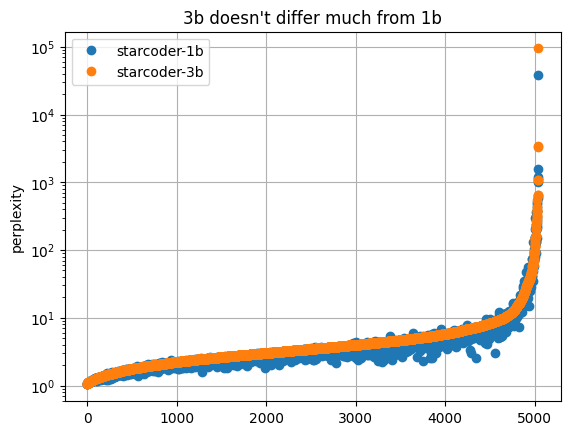

In [153]:
plot_1b_3b(df, log_scale=True)

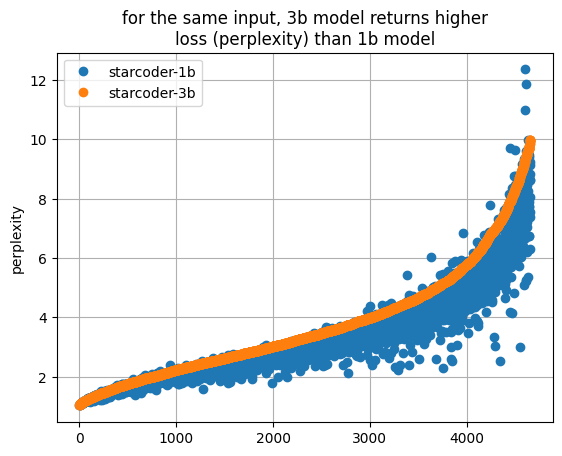

In [154]:
# Trunkate outliers with perplexity > 10
df_trunk = df[df.perp_3b < 10]
plot_1b_3b(df_trunk, title="for the same input, 3b model returns higher\nloss (perplexity) than 1b model")

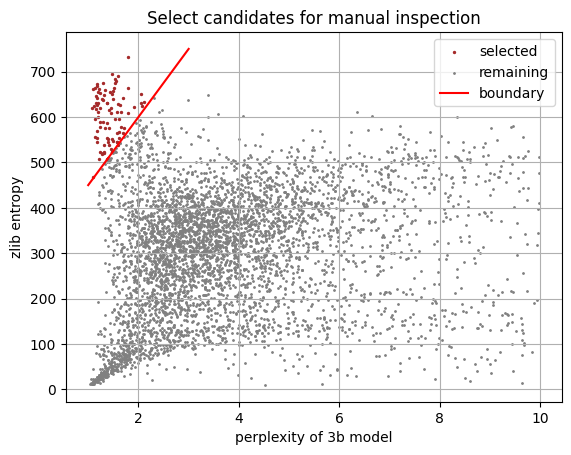

In [155]:
slope = 150
x_intercept = -2
mask = df_trunk.zlib_entropy - (df_trunk.perp_3b - x_intercept) * slope  > 0
df_selected = df_trunk[mask].reset_index()
df_remaining = df_trunk[~mask].reset_index()

plt.scatter(df_selected.perp_3b, df_selected.zlib_entropy, color="brown", s=2, label="selected")
plt.scatter(df_remaining.perp_3b, df_remaining.zlib_entropy, color="gray", s=1, label="remaining")

plt.plot(x:=np.linspace(1, 3, 100), (x - x_intercept) * slope, color="red", label="boundary")

plt.xlabel("perplexity of 3b model")
plt.ylabel("zlib entropy")
plt.title("Select candidates for manual inspection")
plt.grid()
plt.legend()

In [156]:
df_selected.texts.sample(15)

69    0-10\n@***************************************...
51    \n//\n// This is the license of Visual Micro, ...
44    "\n// Licensed to the Apache Software Foundati...
55    ; #*******************************************...
35     /**\n/*\n * Copyright (C) 2017 The LineageOS ...
18     *   *\n * Copyright (C) 2010-2018 <NAME> <<EM...
74    \t// =========================================...
19    _ - - - - - - - - - - -\n-- The MIT License (M...
71    >\n  </body>\n</html>Add a logo to the help pa...
73    \n\npublic object Test4()\n\t/*-\n\t    Copyri...
39    \n# Copyright (c) 2003 - 2014  Test Project\n\...
87    \n/*\nCopyright (c) 2011, SOCIETY STANDARDIZED...
54    .NETte.org\n\n// Copyright (c) 2015-2021 MinIO...
32    3\t\t\n//\tCopyright (c) 2009, <NAME> (email:<...
46    \n/**\n * First we will load all of this proje...
Name: texts, dtype: object

In [157]:
def contains_licence_header(chunk: str) -> bool:
    s = chunk.lower().strip()
    return "licence" in s or "distribution" in s or "copyright" in s or "warrant" in s

contains_licence_mask = df_selected.texts.map(contains_licence_header)
licence_count = contains_licence_mask.sum()
print(f"{licence_count} out of {len(df_selected)} selected code chunks contain some sort of licence agreement")

89 out of 92 selected code chunks contain some sort of licence agreement


In [158]:
# for text in df_selected.texts[~contains_licence_mask]:
#     print(text)
#     print("\n" + "=" * 40 + "\n" + "=" * 40 + "\n")
df_selected.texts[~contains_licence_mask]

46    \n/**\n * First we will load all of this proje...
50     -\n---\n\nname: "💡 Idea"\nabout: Suggest an i...
72    \n\n/**\n * First we will load all of this pro...
Name: texts, dtype: object

I searched GitHub a lot. To avoid cluttering the notebook, here's one example of commonly used code:

In [159]:
js_line = "files.keys().map(key => Vue.component(key.split('/').pop().split('.')[0], files(key).default))"
assert df_selected.texts.map(lambda s: js_line in s).any()
get_gh_occurence_count(js_line)

756

## Conclusion:

I selected 100 out of 5k code chunks generated by starcoderbase-3b.
Those 100 chunks have low perplexity and high zlib entropy.

Overwhelming majority of them turned out to contain boilerplace licence texts.
Exact matches of non-licence code chunks on GitHub are very rare.